In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib
%matplotlib inline
matplotlib.style.use("ggplot")
from matplotlib import pyplot as pp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
import matplotlib.mlab as mlab
from sklearn.model_selection import GridSearchCV


# Import the training data from a csv-file
all_data_train = pd.read_csv("train.csv")

# Import the testing data from a csv-file
all_data_test = pd.read_csv("test.csv")

# get sale price as the target variable and normalize it using log-transformation
target = np.log1p(all_data_train['SalePrice'])

# combine test and train data sets into one and reindex the combined dataset to make the indices unique
new_index = list(range(len(all_data_train), len(all_data_train) + len(all_data_test)))
dataset = pd.concat([all_data_train.drop('SalePrice', 1), pd.DataFrame(data=all_data_test.values, columns=all_data_test.columns, index=(new_index))])

# NaN means no alley
dataset['Alley'].fillna('None', inplace=True)

# NaN means no fence
dataset['Fence'].fillna('None', inplace=True)

# categorical basement-related variables
basement_vars1 = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
# numerical basement-related variables
basement_vars2 = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
# categorical garage-related variables
garage_vars1 = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
# numerical garage-related variables
garage_vars2 = ['GarageYrBlt', 'GarageCars', 'GarageArea']

for i in range(len(dataset)):
    # if the total basement area is 0, all the related variables are alo 0 or 'None'
    # index 2120 contains no value for any of the variables, so they should be 0 or 'None'
    if dataset['TotalBsmtSF'][i] == 0 or i == 2120:
        for var in basement_vars1:
            dataset[var][i] = 'None'
        for var in basement_vars2:
            dataset[var][i] = 0
    # if the number of fireplaces is 0, then its quality is 'None'
    if dataset['Fireplaces'][i] == 0:
        dataset['FireplaceQu'][i] = 'None'
    # if the car capacity of the garage is 0, all the related variables are alo 0 or 'None'
    if dataset['GarageCars'][i] == 0:
        for var in garage_vars1:
            dataset[var][i] = 'None'
        for var in garage_vars2:
            dataset[var][i] = 0
    # if the area of the pool is 0, then its quality is 'None'
    if dataset['PoolArea'][i] == 0:
        dataset['PoolQC'][i] = 'None'
    # if the value of the miscellaneous feature is 0, then it is 'None'
    if dataset['MiscVal'][i] == 0:
        dataset['MiscFeature'][i] = 'None'

# Numerical variable with "categorical meaning"
# Cast it to str so that we get dummies later on
dataset['MSSubClass'] = dataset['MSSubClass'].astype(str)

# MasVnrArea > 0 for these index values
dataset['MasVnrType'][[624, 773, 1230, 1300, 1334, 1669, 2452]] = np.nan

### feature engineering ###
# create new binary variables: assign 1 to mode
dataset['IsRegularLotShape'] = (dataset['LotShape'] == 'Reg') * 1
dataset['IsLandLevel'] = (dataset['LandContour'] == 'Lvl') * 1
dataset['IsLandSlopeGentle'] = (dataset['LandSlope'] == 'Gtl') * 1
dataset['IsElectricalSBrkr'] = (dataset['Electrical'] == 'SBrkr') * 1
dataset['IsGarageDetached'] = (dataset['GarageType'] == 'Detchd') * 1
dataset['IsPavedDrive'] = (dataset['PavedDrive'] == 'Y') * 1
dataset['HasShed'] = (dataset['MiscFeature'] == 'Shed') * 1
# was the house remodeled? if yes, assign 1
dataset['Remodeled'] = (dataset['YearRemodAdd'] != dataset['YearBuilt']) * 1
# assign 1 to houses which were sold the same year they were remodeled
dataset['RecentRemodel'] = (dataset['YearRemodAdd'] == dataset['YrSold']) * 1
# assign 1 to houses which were sold the same year they were built
dataset['VeryNewHouse'] = (dataset['YearBuilt'] == dataset['YrSold']) * 1

# separate data set back into training and testing sets
train_len = len(all_data_train)
data_train = dataset[:train_len]
data_test = dataset[train_len:]
target = target.to_frame()

# remove outliers in GrLivArea
target.drop(target[data_train['GrLivArea'] > 4500].index, inplace=True)
target = pd.DataFrame(data=target.values, columns=target.columns, index=list(range(len(target))))
data_train.drop(data_train[data_train['GrLivArea'] > 4500].index, inplace=True)
data_train = pd.DataFrame(data=data_train.values, columns=data_train.columns, index=list(range(len(data_train))))

# combine training and testing data sets again
new_index = list(range(len(data_train), len(data_train) + len(data_test)))
dataset = pd.concat([data_train, pd.DataFrame(data=data_test.values, columns=data_test.columns, index=(new_index))])

In [2]:
def create_dummy_variables(data):
    string_data = data.select_dtypes(exclude=[np.number])
    new_data = data.copy()
    for column in string_data:
        one_hot = pd.get_dummies(string_data[column])
        # reorder columns for ordinal variables
        if column == 'LotShape':
            one_hot = one_hot[['IR3', 'IR2', 'IR1', 'Reg']]
        elif column == 'ExterQual' or column == 'KitchenQual':
            one_hot = one_hot[['Fa', 'TA', 'Gd', 'Ex']]
        elif column == 'ExterCond' or column == 'HeatingQC':
            one_hot = one_hot[['Po', 'Fa', 'TA', 'Gd', 'Ex']]
        elif column == 'BsmtQual':
            one_hot = one_hot[['None', 'Fa', 'TA', 'Gd', 'Ex']]
        elif column == 'BsmtCond':
            one_hot = one_hot[['None', 'Po', 'Fa', 'TA', 'Gd']]
        elif column == 'BsmtExposure':
            one_hot = one_hot[['None', 'No', 'Mn', 'Av', 'Gd']]
        elif column == 'BsmtFinType1' or column == 'BsmtFinType2':
            one_hot = one_hot[['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']]
        elif column == 'Functional':
            one_hot = one_hot[['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']]
        elif column == 'FireplaceQu' or column == 'GarageQual' or column == 'GarageCond':
            one_hot = one_hot[['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']]
        elif column == 'GarageFinish':
            one_hot = one_hot[['None', 'Unf', 'RFn', 'Fin']]
        elif column == 'PoolQC':
            one_hot = one_hot[['None', 'Fa', 'Gd', 'Ex']]
        if column == 'Fence':
            one_hot = one_hot[['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']]
        # if a variable contains 'None', put it in front to assign 0 to it
        elif 'None' in one_hot.columns:
            one_hot = one_hot[['None'] + one_hot.columns.drop('None').tolist()]
        # if a variable contains 'Oth' (Other), put it in front to assign 0 to it
        elif 'Oth' in one_hot.columns:
            one_hot = one_hot[['Oth'] + one_hot.columns.drop('Oth').tolist()]
        vals = one_hot.values
        dummies = np.zeros(len(vals))
        for i in range(len(vals)):
            dummy = np.argwhere(vals[i]==1)
            if len(dummy) == 0:
                dummy = np.nan
            else:
                dummy = dummy[0,0]
            dummies[i] = dummy
        new_data = new_data.drop(column, 1)
        new_data[column] = dummies
    return new_data

# replace values of string variables with dummies
dataset = create_dummy_variables(dataset)

In [3]:
# gather variables with missing values together
complete_data = pd.DataFrame()
incomplete_data = pd.DataFrame()
for column in dataset:
    if dataset[column].isnull().values.any():
        incomplete_data[column] = dataset[column]
    else:
        complete_data[column] = dataset[column]
    
# sort incomplete data variables from lowest number of missing values to highest
missing = np.sum(incomplete_data.isnull(), 0)
incomplete_data = incomplete_data.append(missing.to_frame('missing').transpose())
incomplete_data.sort_values(by='missing', axis=1, inplace=True)
incomplete_data.drop('missing', inplace=True)

print('Number of complete variables:', len(complete_data.columns))
print('Number of incomplete variables:', len(incomplete_data.columns))
print('\nNumber of missing values in each variable:')
print(np.sum(incomplete_data.isnull()))

Number of complete variables: 67
Number of incomplete variables: 23

Number of missing values in each variable:
Electrical        1
GarageArea        1
GarageCars        1
KitchenQual       1
MiscFeature       1
BsmtFinType2      1
SaleType          1
Exterior2nd       1
Exterior1st       1
BsmtQual          2
Functional        2
GarageYrBlt       2
GarageFinish      2
Utilities         2
GarageQual        2
GarageCond        2
BsmtCond          3
BsmtExposure      3
PoolQC            3
MSZoning          4
MasVnrArea       23
MasVnrType       31
LotFrontage     486
dtype: int64


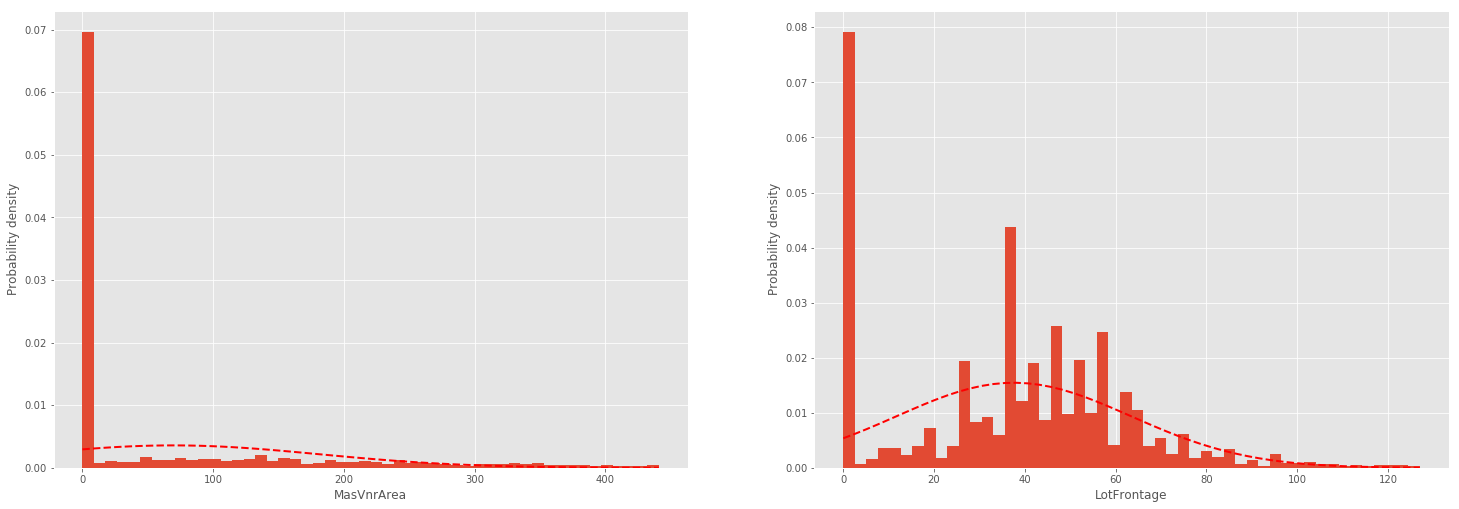

In [4]:
def plot_distribution(to_be_plotted, data):
    dataSet = data.copy()
    plt.figure(figsize=(25, 180))
    for i, entry in enumerate(to_be_plotted):
        plt.subplot(18, 2, i+1)
        # fill NaNs with 0
        dataSet[entry].fillna(0, inplace=True)
        # mean distribution
        mu = dataSet[entry].mean()
        # std distribution
        sigma = dataSet[entry].std()
        num_bins = 50
        n, bins, patches = plt.hist(dataSet[entry], num_bins, normed=1)
        y = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--', linewidth=2)
        plt.xlabel(entry)
        plt.ylabel('Probability density')
        plt.grid(True)
    plt.show()
    
plot_distribution(['MasVnrArea', 'LotFrontage'], dataset)

In [5]:
# drop Id
complete_data.drop('Id', axis=1, inplace=True)

# list of continuous variables
continuous_vars = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch',\
            'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'MiscVal',\
            'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF']

# continuous variables in the complete data set
continuous_vars_complete = []
for entry in continuous_vars:
    if entry in complete_data:
        continuous_vars_complete.append(entry)

### normalization ###
# normalize distribution for continuous variables with skew > 3
skew_threshold = 3
for entry in continuous_vars_complete:
    if complete_data[entry].skew() > skew_threshold:
        complete_data[entry] = np.log1p(complete_data[entry])
    
    
### standardization ###
# standardization for continuous variables
sub_df = complete_data[continuous_vars_complete]
array_standard = StandardScaler().fit_transform(sub_df)
df_standard = pd.DataFrame(array_standard, complete_data.index, continuous_vars_complete)
complete_data.drop(complete_data[continuous_vars_complete], axis=1, inplace=True)
complete_data = pd.concat([complete_data, df_standard], axis=1)


In [6]:
def fill_gaps(classifier, regressor):
    # Using complete data as predictor, guess missing values in incomplete data
    # columns one by one starting from the variable with the fewest missing values.
    # Use regressor for numerical variables, classifier for categorical ones.
    # After filling in the missing values, move the variable to complete data and
    # start the whole process again.
    completeData = complete_data.copy()
    incompleteData = incomplete_data.copy()
    for column in incompleteData:
        y = incompleteData[[column]]
        # data points with missing values will be predicted
        y_test = pd.DataFrame()
        # the remaining data points will be trained on
        y_train = pd.DataFrame()
        for i in range(len(y)):
            value = y.iloc[i][column]
            if pd.isnull(value):
                y_test = y_test.append(y.iloc[[i]])
            else:
                y_train = y_train.append(y.iloc[[i]])
        if not(y_test.empty):
            X_test = completeData.loc[y_test.index]
            X_train = completeData.loc[y_train.index]
            if column in continuous_vars:            
                ### normalization ###
                # normalize distribution for continuous variables with skew > 3
                skew_threshold = 3
                if y_train[column].skew() > skew_threshold:
                    y_train = np.log1p(y_train)

                ### standardization ###
                # standardization for continuous variables
                array_standard = StandardScaler().fit_transform(y_train[column])
                y_train = pd.DataFrame(array_standard, y_train.index, [column])

                regressor.fit(X = X_train, y = y_train[column])
                for i, value in enumerate(regressor.predict(X_test)):
                    y_test.iloc[[i]] = value
                y = y_train.append(y_test)
                y.sort_index(inplace=True)
            else:
                classifier.fit(X = X_train, y = y_train[column])
                for i, value in enumerate(classifier.predict(X_test)):
                    y_test.iloc[[i]] = value
                y = y_train.append(y_test)
                y.sort_index(inplace=True)
            completeData[column] = y
    return completeData

In [7]:
# Data for Random Forest Regressor
random_forest_data = fill_gaps(RandomForestClassifier(), RandomForestRegressor())

# Data for AdaBoost Regressor
ada_boost_data = fill_gaps(AdaBoostClassifier(), AdaBoostRegressor())

# Data for Gradient Boosting Regressor
gradient_boosting_data = fill_gaps(GradientBoostingClassifier(), GradientBoostingRegressor())

# Data for Extra-Trees Regressor
extra_trees_data = fill_gaps(ExtraTreesClassifier(), ExtraTreesRegressor())

# Data for Bagging Regressor
bagging_data = fill_gaps(BaggingClassifier(), BaggingRegressor())

# Data for Lasso linear model
lasso_data = fill_gaps(GradientBoostingClassifier(), LassoCV(max_iter=10000))

# Data for Ridge regression
ridge_data = fill_gaps(GradientBoostingClassifier(), RidgeCV())

# Data for Elastic Net model
elastic_net_data = fill_gaps(GradientBoostingClassifier(), ElasticNetCV(max_iter=10000))



C:\Users\Turan Orujlu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Turan Orujlu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Turan Orujlu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your 

C:\Users\Turan Orujlu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Turan Orujlu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Turan Orujlu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your 

C:\Users\Turan Orujlu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Turan Orujlu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Turan Orujlu\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your 

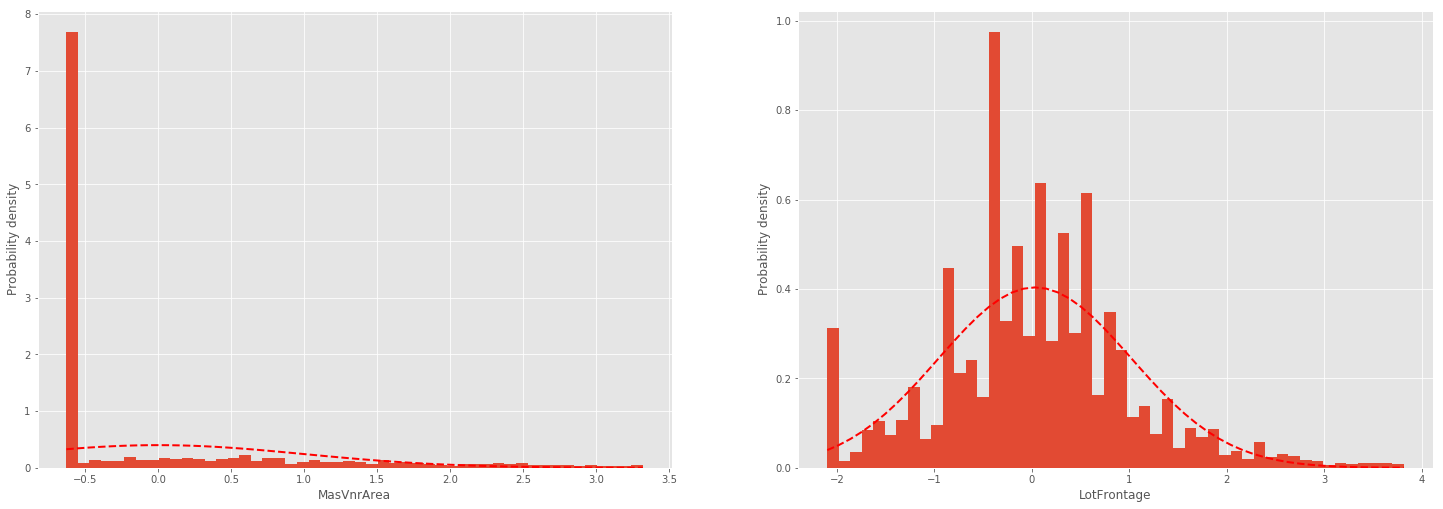

In [8]:
plot_distribution(['MasVnrArea', 'LotFrontage'], random_forest_data)

In [9]:
train_len = len(target)

# Training and testing data for Random Forest Regressor
random_forest_train = random_forest_data[:train_len]
random_forest_test = random_forest_data[train_len:]

# Training and testing data for AdaBoost Regressor
ada_boost_train = ada_boost_data[:train_len]
ada_boost_test = ada_boost_data[train_len:]

# Training and testing data for Gradient Boosting Regressor
gradient_boosting_train = gradient_boosting_data[:train_len]
gradient_boosting_test = gradient_boosting_data[train_len:]

# Training and testing data for Extra-Trees Regressor
extra_trees_train = extra_trees_data[:train_len]
extra_trees_test = extra_trees_data[train_len:]

# Training and testing data for Bagging Regressor
bagging_train = bagging_data[:train_len]
bagging_test = bagging_data[train_len:]

# Training and testing data for Lasso linear model
lasso_train = lasso_data[:train_len]
lasso_test = lasso_data[train_len:]

# Training and testing data for Ridge regression
ridge_train = ridge_data[:train_len]
ridge_test = ridge_data[train_len:]

# Training and testing data for Elastic Net model
elastic_net_train = elastic_net_data[:train_len]
elastic_net_test = elastic_net_data[train_len:]

validation_size = 0.2
seed = 3

In [10]:
# list of tuples: the first element is a string, the second is an object
estimators = [('RandomForest', RandomForestRegressor()), ('GradientBoosting', GradientBoostingRegressor()),\
              ('AdaBoost', AdaBoostRegressor()), ('ExtraTrees', ExtraTreesRegressor()),\
              ('Bagging', BaggingRegressor()), ('LassoCV', LassoCV(max_iter=10000)), ('RidgeCV', RidgeCV()),\
              ('ElasticNetCV', ElasticNetCV(max_iter=10000))]

train_sets = [random_forest_train, gradient_boosting_train, ada_boost_train, extra_trees_train, bagging_train,\
             lasso_train, ridge_train, elastic_net_train]
test_sets = [random_forest_test, gradient_boosting_test, ada_boost_test, extra_trees_test, bagging_test,\
            lasso_test, ridge_test, elastic_net_test]

for method in range(len(estimators)):
    estimator = estimators[method]
    data_train = train_sets[method]
    data_test = test_sets[method]
    X_train, X_validation, y_train, y_validation = train_test_split(data_train, target, \
            test_size=validation_size, random_state=seed)
    X_test = data_test
    scores = cross_val_score(estimator=estimator[1],
                            X=X_train,
                            y=y_train,
                            scoring='r2',
                            cv=3,
                            n_jobs=-1)
    #print('CV accuracy scores: %s' % scores)
    print(estimator[0], 'CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

RandomForest CV accuracy: 0.873 +/- 0.004
GradientBoosting CV accuracy: 0.904 +/- 0.007
AdaBoost CV accuracy: 0.824 +/- 0.017
ExtraTrees CV accuracy: 0.872 +/- 0.001
Bagging CV accuracy: 0.871 +/- 0.017
LassoCV CV accuracy: 0.896 +/- 0.006
RidgeCV CV accuracy: 0.900 +/- 0.005
ElasticNetCV CV accuracy: 0.896 +/- 0.006


In [11]:
#LassoCV
gs = GridSearchCV(
                estimator=LassoCV(max_iter=10000),
                param_grid={'eps':[10**-7, 10**-5, 10**-3],
                            'n_alphas':[25, 50, 75]},
                scoring='r2',
                cv=3,
                n_jobs=-1)

X_train, X_validation, y_train, y_validation = train_test_split(lasso_train, target, \
                                                                test_size=validation_size, random_state=seed)
X_test = lasso_test
gs = gs.fit(X_train, y_train)
print('LassoCV:')
print('Training accuracy: %.3f' % gs.best_score_)
print(gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Best alpha: ', est.alpha_)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

LassoCV:
Training accuracy: 0.899
{'n_alphas': 25, 'eps': 1e-05}
Best alpha:  0.000184101098618
Validation accuracy: 0.884


In [12]:
#RidgeCV
gs = GridSearchCV(
                estimator=RidgeCV(),
                param_grid={'fit_intercept':[True, False],
                            'normalize':[True, False]},
                scoring='r2',
                cv=3,
                n_jobs=-1)

X_train, X_validation, y_train, y_validation = train_test_split(ridge_train, target, \
                                                                test_size=validation_size, random_state=seed)
X_test = ridge_test
gs = gs.fit(X_train, y_train)
print('RidgeCV:')
print('Training accuracy: %.3f' % gs.best_score_)
print(gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Best alpha: ', est.alpha_)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

RidgeCV:
Training accuracy: 0.903
{'normalize': True, 'fit_intercept': True}
Best alpha:  0.1
Validation accuracy: 0.885


In [13]:
#RandomForest
gs = GridSearchCV(
                estimator=RandomForestRegressor(random_state=seed),
                param_grid={'max_depth':[3, 10, 20],
                            'n_estimators':[10, 30, 50]},
                scoring='r2',
                cv=3,
                n_jobs=-1)

X_train, X_validation, y_train, y_validation = train_test_split(random_forest_train, target, \
                                                                test_size=validation_size, random_state=seed)
X_test = random_forest_test
gs = gs.fit(X_train, y_train)
print('Random Forest:')
print('BR: ', gs.best_score_)
print('BR: ', gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

Random Forest:
BR:  0.883878918996
BR:  {'max_depth': 20, 'n_estimators': 50}
Validation accuracy: 0.861


In [14]:
#GradientBoosting
gs = GridSearchCV(
                estimator=GradientBoostingRegressor(random_state=seed),
                param_grid={'max_depth':[3, 10],
                            'learning_rate':[0.1, 0.03],
                            'n_estimators':[100, 250, 500]},
                scoring='r2',
                cv=3,
                n_jobs=-1)

X_train, X_validation, y_train, y_validation = train_test_split(gradient_boosting_train, target, \
                                                                test_size=validation_size, random_state=seed)
X_test = gradient_boosting_test
gs = gs.fit(X_train, y_train)
print('Gradient Boosting:')
print('BR: ', gs.best_score_)
print('BR: ', gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

Gradient Boosting:
BR:  0.908547420267
BR:  {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 500}
Validation accuracy: 0.896


In [15]:
#ElasticNet
gs = GridSearchCV(
                estimator=ElasticNetCV(max_iter=10000, random_state=seed),
                param_grid={'l1_ratio':[0.8, 0.85],
                            'eps':[10**-8,10**-9]},
                scoring='r2',
                cv=3,
                n_jobs=-1)


X_train, X_validation, y_train, y_validation = train_test_split(elastic_net_train, target, \
                                                                test_size=validation_size, random_state=seed)
X_test = elastic_net_test
gs = gs.fit(X_train, y_train)
print('Elastic Net:')
print('EN: ', gs.best_score_)
print('EN: ', gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Best alpha: ', est.alpha_)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

Elastic Net:
EN:  0.898450716651
EN:  {'l1_ratio': 0.8, 'eps': 1e-08}
Best alpha:  0.00116549884562
Validation accuracy: 0.890


In [16]:
#AdaBoost
gs = GridSearchCV(
                estimator=AdaBoostRegressor(random_state=seed),
                param_grid={'learning_rate':[2.0, 0.1, 0.03],
                            'n_estimators':[50,150, 200]},
                scoring='r2',
                cv=3,
                n_jobs=-1)

X_train, X_validation, y_train, y_validation = train_test_split(ada_boost_train, target, \
                                                                test_size=validation_size, random_state=seed)
X_test = ada_boost_test
gs = gs.fit(X_train, y_train)
print('AdaBoost:')
print('BR: ', gs.best_score_)
print('BR: ', gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

AdaBoost:
BR:  0.848578110819
BR:  {'learning_rate': 2.0, 'n_estimators': 200}
Validation accuracy: 0.810


In [17]:
#ExtraTrees
gs = GridSearchCV(
                estimator=ExtraTreesRegressor(random_state=seed),
                param_grid={'max_depth':[3, 10, 20],
                            'n_estimators':[10, 30, 50]},
                scoring='r2',
                cv=3,
                n_jobs=-1)

X_train, X_validation, y_train, y_validation = train_test_split(extra_trees_train, target, \
                                                                test_size=validation_size, random_state=seed)
X_test = extra_trees_test
gs = gs.fit(X_train, y_train)
print('Extra-Trees:')
print('BR: ', gs.best_score_)
print('BR: ', gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

Extra-Trees:
BR:  0.887637804232
BR:  {'max_depth': 20, 'n_estimators': 50}
Validation accuracy: 0.879


In [18]:
#Bagging
gs = GridSearchCV(
                estimator=BaggingRegressor(random_state=seed),
                param_grid={'max_samples':[0.3, 0.6, 1.0],
                            'max_features':[0.3, 0.6, 1.0],
                            'n_estimators':[50, 150, 200]},
                scoring='r2',
                cv=3,
                n_jobs=-1)

X_train, X_validation, y_train, y_validation = train_test_split(bagging_train, target, \
                                                                test_size=validation_size, random_state=seed)
X_test = bagging_test
gs = gs.fit(X_train, y_train)
print('Bagging:')
print('BR: ', gs.best_score_)
print('BR: ', gs.best_params_)
est = gs.best_estimator_
est.fit(X_train, y_train)
print('Validation accuracy: %.3f' % est.score(X_validation, y_validation))

Bagging:
BR:  0.890060586682
BR:  {'max_samples': 1.0, 'max_features': 0.6, 'n_estimators': 200}
Validation accuracy: 0.875
